In [1]:
import pandas as pd
df = pd.read_excel('data_process_all.xlsx')

# 计算文本加权情感强度

In [2]:
#文本加权情感强度计算公式为：整体情感极性*K（是否为长文本）*（分词情感强度绝对值+emoji数量*3）/分词长度
#其中，整体情感极性由百度API提供；长文本权重为1.5，短文本权重为1
import numpy as np
df['weighted_score']=0
for i in range(len(df)):
    try:
        num_emoji=len(df['weibo_emoji'][i].split(","))
    except:
        num_emoji=0
    length=df['length'][i]
    emo_score=abs(df['emo_score'][i])
    if df['isLongText'][i]:
        k=1.5
    else:
        k=1
    if df['baidu_pm'][i]=="正向":
        emo=1
    else:
        emo=-1
    df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
df['weighted_score']=df['weighted_score'].fillna(value=0)
df['weighted_score'][np.isinf(df['weighted_score'])] = 0

<ipython-input-2-7a15bf443485>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
<ipython-input-2-7a15bf443485>:20: RuntimeWarning: invalid value encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
<ipython-input-2-7a15bf443485>:20: RuntimeWarning: divide by zero encountered in double_scalars
  df['weighted_score'][i]=emo*k*(emo_score+num_emoji*3)/length
<ipython-input-2-7a15bf443485>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weighted_score'][np.isinf(df['weighted_score'])] = 0


In [27]:
df[['isLongText','baidu_pm','weibo_emoji','length','emo_score','weighted_score']].sample(n=10)

,isLongText,baidu_pm,weibo_emoji,length,emo_score,weighted_score
2306,False,负向,NaN,14,0.0,-0.000000
41,False,负向,NaN,18,-5.0,-0.277778
2752,False,正向,NaN,7,3.0,0.428571
2585,False,正向,NaN,1,7.0,7.000000
6223,False,负向,NaN,4,0.0,-0.000000
1813,False,正向,"good,熊猫",6,10.0,2.666667
5681,False,负向,NaN,2,-5.0,-2.500000
4473,False,负向,NaN,7,-5.0,-0.714286
5211,False,负向,NaN,14,-13.0,-0.928571
1001,False,负向,NaN,42,-5.0,-0.119048


# 微博话题强度计算

In [28]:
#情感强度第一定律公式μ=K*log(1+△p)，其中K与事件话题敏感度有关，此处为较敏感事件，取K=2
#价值率高差计算公式：△p=(Ci-Cmin)/(Cmax-Cmin),其中i为时间段，C为时间戳中转评赞总和
import datetime
#数据是从22年2月到23年四月底，其中由于23.4.7官方发布相关消息，讨论度变化较大，故取前后一段时间舆论强度变化作为示例
START=datetime.datetime.strptime("2023-4-7 0:00:00", '%Y-%m-%d %H:%M:%S')
END=datetime.datetime.strptime("2023-4-10 0:00:00", '%Y-%m-%d %H:%M:%S')

#划分时间戳
start=[]
end=[]
h=2
begin=START
while begin<END:
    start.append(begin)
    end.append(begin+datetime.timedelta(hours=h))
    begin=begin+datetime.timedelta(hours=h)

C=[0 for i in range(len(start))]
Stext=[0 for i in range(len(start))]
for i in range(len(df)):
    if df['isLongText'][i]:
        k=3
    else:
        k=1
    time=df['created_at'][i]
    count=df['comments_count'][i]+df['attitudes_count'][i]+df['reposts_count'][i]+k #计数=转赞评+文本（是否为长文本）
    score=df['weighted_score'][i]
    for j in range(len(start)):
        if time>=start[j] and time<end[j]:
            C[j]+=count
            Stext[j]+=score
Stopic=[0 for i in range(len(start))]
for j in range(len(C)):
    p=(C[j]-min(C))/(max(C)-min(C))
    Stopic[j]=2*np.log(1+p)

# 综合情感计算及舆情变化趋势检测

In [29]:
SE=[0 for i in range(len(start))]
for i in range(len(C)):
    SE[i]=abs(Stext[i]*Stopic[i]/2)

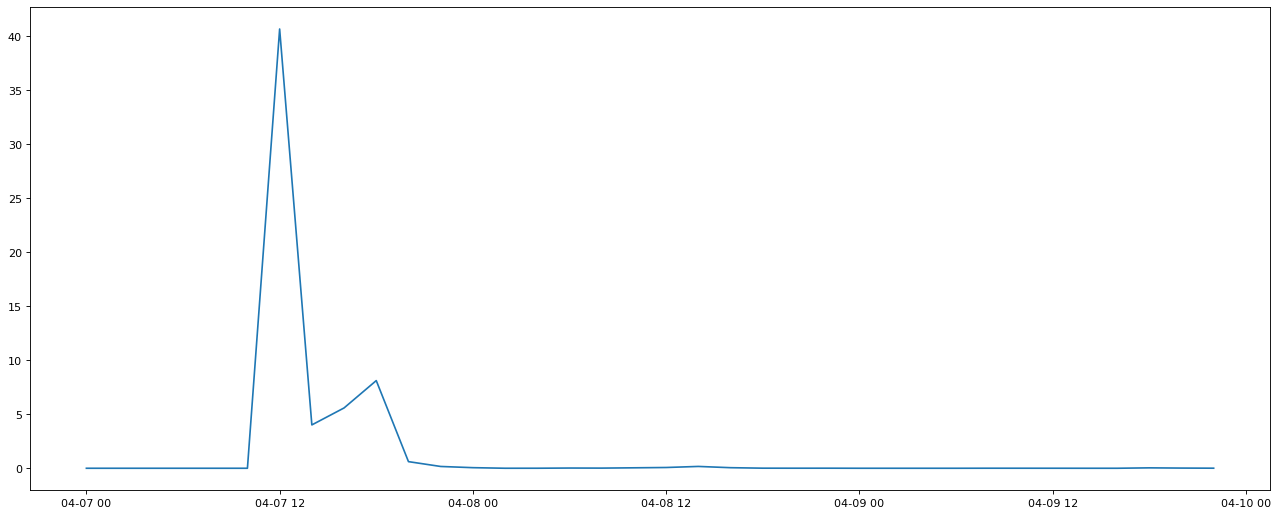

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start,SE)

In [31]:
#舆情变化率近似于(SEt+1-SEt)/T
#其中T为时间间隔，即一个时间戳长度
y=[(SE[i+1]-SE[i])/h for i in range(len(SE)-1)]

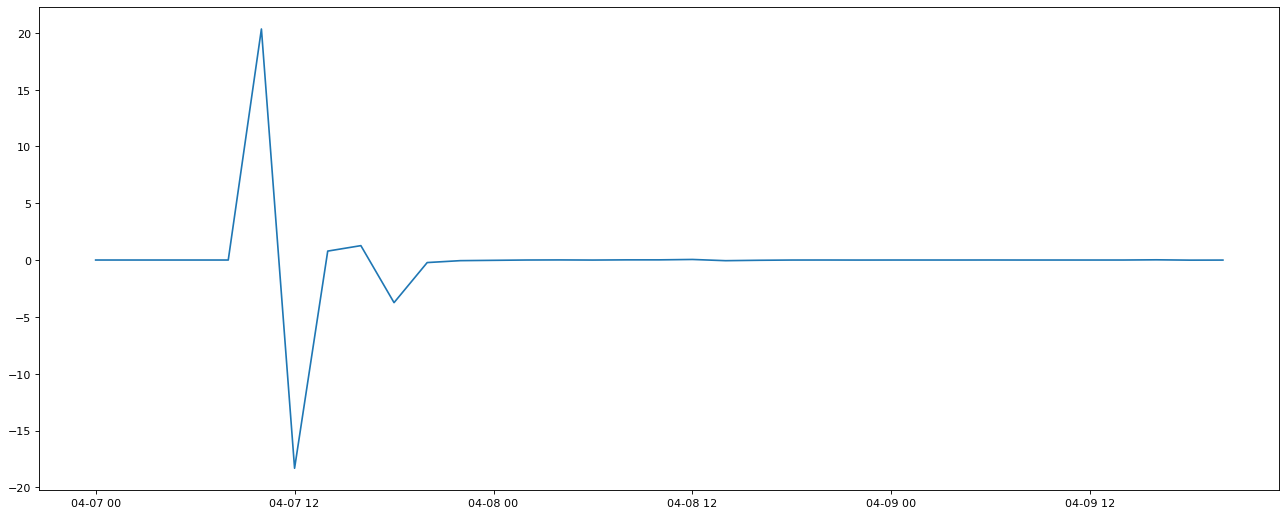

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8),dpi=80)    
plt.plot(start[:len(start)-1],y)